In [1]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/offline 2 dataset/Dataset A.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training-a/a14702.png   
  inflating: training-a/a14703.png   
  inflating: training-a/a14704.png   
  inflating: training-a/a14705.png   
  inflating: training-a/a14706.png   
  inflating: training-a/a14707.png   
  inflating: training-a/a14708.png   
  inflating: training-a/a14709.png   
  inflating: training-a/a14710.png   
  inflating: training-a/a14711.png   
  inflating: training-a/a14712.png   
  inflating: training-a/a14713.png   
  inflating: training-a/a14714.png   
  inflating: training-a/a14715.png   
  inflating: training-a/a14716.png   
  inflating: training-a/a14717.png   
  inflating: training-a/a14718.png   
  inflating: training-a/a14719.png   
  inflating: training-a/a14720.png   
  inflating: training-a/a14721.png   
  inflating: training-a/a14722.png   
  inflating: training-a/a14723.png   
  inflating: training-a/a14724.png   
  inflating: training-a/a14725.png   
  inflating: training-a/a14726.png   

In [4]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [5]:
a_csv = showRawTrainingSamples('training-a.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')


In [6]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [7]:
a_csv = dropColumns(a_csv)

         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0


**Preparing Dataset**

In this section I have processed the dataset. The Dataset class takes csv, path and transformation as input and returns the image and image label

In [8]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [10]:
TRAIN_PATH = 'training-a'
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(a_csv, TRAIN_PATH, train_transform)
test_data = Dataset(a_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))


Trainig Samples:  19702


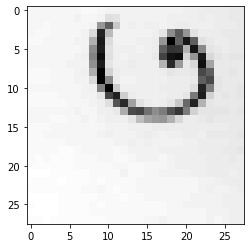

In [11]:
#An example of training data


show_img = train_data[6][0].numpy().reshape(28,28)
plt.imshow(show_img, cmap = 'gray')

In [12]:
# mix data
# index of num of train
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)


**Experiment 1**

# **Hyperparameters**
- **totaldata:** 19702
- **batch:** 20
  - Number of examples in **1** iteration

- **iterations:** 20000

- **learning rate:** 0.01 
  - the hyperparameter that controls how much the model changes in response to the estimated error

- **No. of nodes in Hidden Layer:** 200
- **No. of Hidden Layers:** 6
- **Activation Function:** ReLU
- **Optimizer & Loss:** SGD

In [13]:
#nodes: 200, hidden layers: 6, all ReLU, SGD
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28 #num_features = 784
num_hidden = 200
output_dim = 10

learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler =test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print('num of epoch',num_epochs)

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss=[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Train dataloader:789
Test dataloader:197
num of epoch 20
Iteration: 500. Loss: 2.3028500080108643. Accuracy: 14.644670050761421
Iteration: 1000. Loss: 2.310727834701538. Accuracy: 10.583756345177665
Iteration: 1500. Loss: 2.289724588394165. Accuracy: 10.406091370558375
Iteration: 2000. Loss: 2.294062376022339. Accuracy: 9.949238578680204
Iteration: 2500. Loss: 2.2940192222595215. Accuracy: 17.893401015228427
Iteration: 3000. Loss: 2.2960968017578125. Accuracy: 12.563451776649746
Iteration: 3500. Loss: 2.218334436416626. Accuracy: 21.243654822335024
Iteration: 4000. Loss: 2.292940855026245. Accuracy: 28.248730964467004
Iteration: 4500. Loss: 2.0615897178649902. Accuracy: 18.14720812182741
Iteration: 5000. Loss: 2.167956829071045. Accuracy: 23.375634517766496
Iteration: 5500. Loss: 2.1272358894348145. Accuracy: 24.949238578680202
Iteration: 6000. Loss: 1.8516356945037842. Accuracy: 39.23857868020305
Iteration: 6500. Loss: 1.936944603919983. Accuracy: 30.253807106598984
Iteration: 7000. L

[2.3028500080108643, 2.310727834701538, 2.289724588394165, 2.294062376022339, 2.2940192222595215, 2.2960968017578125, 2.218334436416626, 2.292940855026245, 2.0615897178649902, 2.167956829071045, 2.1272358894348145, 1.8516356945037842, 1.936944603919983, 1.8142421245574951, 1.7771492004394531, 1.9105770587921143, 1.6606041193008423, 1.7283194065093994, 1.1261208057403564, 1.1648328304290771, 1.4757874011993408, 1.412708044052124, 0.9498342275619507, 1.2086337804794312, 1.5997143983840942, 0.7193577289581299, 1.004536509513855, 1.2705692052841187, 0.9185417294502258, 1.6693077087402344, 0.9571126699447632]


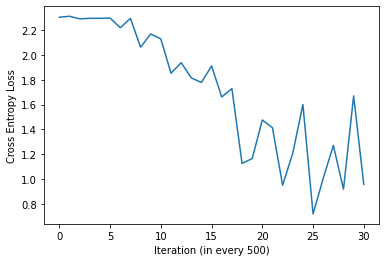

In [14]:
#--------------Done----------------
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
#print(accuracies)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Result:**


> Cross Entropy Loss: 0.95 
  || Accuracy: 65.02%


**Experiment 2**


# **Hyperparameters**
* **Batch Size:**64 
* **Iterations:**35,000
* **Epoch:**40
* **Nodes:**256
* **Total Layers:4**
* **Activation Functions:**ELU-ELU-ELU-ELU
* **Optimizer:** Adam
* **Learning Rate:** 3e-4

In [17]:
#256 nodes, 4 layer, ELU-ELU-ELU-ELU, Adam
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 64
num_iters = 35000
input_dim = 28*28 #num_features = 784
num_hidden = 256
output_dim = 10

learning_rate = 3e-4

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler =test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print('num of epoch',num_epochs)

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ELU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ELU()


        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ELU()


        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iteration_loss=[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Train dataloader:247
Test dataloader:62
num of epoch 113
Iteration: 500. Loss: 1.1441627740859985. Accuracy: 61.11675126903553
Iteration: 1000. Loss: 1.0630364418029785. Accuracy: 61.47208121827411
Iteration: 1500. Loss: 0.8789758086204529. Accuracy: 70.45685279187818
Iteration: 2000. Loss: 1.0980160236358643. Accuracy: 69.31472081218274
Iteration: 2500. Loss: 0.8294020891189575. Accuracy: 60.63451776649746
Iteration: 3000. Loss: 0.5629484057426453. Accuracy: 69.8984771573604
Iteration: 3500. Loss: 0.967200517654419. Accuracy: 76.26903553299492
Iteration: 4000. Loss: 0.4872433543205261. Accuracy: 80.50761421319797
Iteration: 4500. Loss: 0.3998975157737732. Accuracy: 79.8984771573604
Iteration: 5000. Loss: 0.5049535632133484. Accuracy: 78.57868020304568
Iteration: 5500. Loss: 0.3981471657752991. Accuracy: 76.34517766497461
Iteration: 6000. Loss: 0.6359761953353882. Accuracy: 79.13705583756345
Iteration: 6500. Loss: 0.3130567669868469. Accuracy: 76.92893401015229
Iteration: 7000. Loss: 0

**Result:**


> Cross Entropy Loss: 0.04% || Accuracy: 91.29%



[1.1441627740859985, 1.0630364418029785, 0.8789758086204529, 1.0980160236358643, 0.8294020891189575, 0.5629484057426453, 0.967200517654419, 0.4872433543205261, 0.3998975157737732, 0.5049535632133484, 0.3981471657752991, 0.6359761953353882, 0.3130567669868469, 0.5505328178405762, 0.2936496436595917, 0.3651917278766632, 0.41106903553009033, 0.44564878940582275, 0.40375667810440063, 0.46388229727745056, 0.2904052138328552, 0.4416431188583374, 0.3374382257461548, 0.28678861260414124, 0.30889275670051575, 0.5965989828109741, 0.34827589988708496, 0.13163502514362335, 0.19541087746620178, 0.1310712993144989, 0.25554871559143066, 0.23345041275024414, 0.18659327924251556, 0.8678048849105835, 0.1501702070236206, 0.11739178001880646, 0.21660253405570984, 0.14857053756713867, 0.20723286271095276, 0.1513826996088028, 0.08116763830184937, 0.0681709572672844, 0.10284417867660522, 0.32781562209129333, 0.2621762156486511, 0.14236478507518768, 0.1125360056757927, 0.11115902662277222, 0.05302466079592705

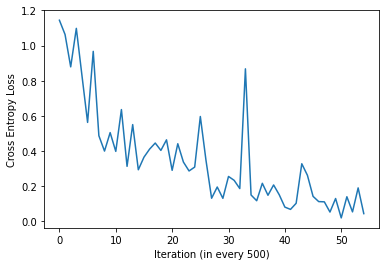

In [18]:
#--------------Done----------------
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
#print(accuracies)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Experiments Using Dataset 2**

In [19]:
!unzip '/content/drive/MyDrive/offline 2 dataset/Dataset_2.zip'

Archive:  /content/drive/MyDrive/offline 2 dataset/Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


**Conclusion**

A summary of the obtained results is given below:

|Hyperparameters| No. of hidden layer| Activation Function Each Layer|No. of Neuron| Cross Entropy Loss| Accuracy
| :-----------------| :-----------------:| :----------: | :-----------: |:-----------: |-----------: |
|Batch Size:20,Iter:20000,Optimizer:SGD,LR:0.01 |6| All ReLU|200|0.95|65.02%
|Batch Size:64,Iter:35000,Optimizer:Adam,LR:3e-4|4|ELU-ELU-ELU-ELU|256|0.04|91.29%